In [55]:
import pandas as pd
import numpy as np
import os
import time
import random
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-whitegrid')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# Mount Google drive folder
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [57]:
# Setup working directory and data directory
DIR = '/content/drive/My Drive/Colab Notebooks/EvenSem2021MAHE/Classifiers'
DATA_DIR = DIR + '/Data/SimulatedData/'
os.chdir(DIR)

In [59]:
# Function to simulate data
def GenerateSimulatedData(num_samples = 9000, num_features = 2, num_labels = 3):
    X = np.zeros((num_features, num_samples)) # data matrix (each column = single sample)
    y = np.zeros(num_samples, dtype = 'uint8') # class labels
    for j in range(num_labels):
      ix = range((num_samples//num_labels)*j, (num_samples//num_labels)*(j+1))
      r = np.linspace(0.0, 1.0, num_samples//num_labels) # radius
      t = np.linspace(j*4, (j+1)*4, num_samples//num_labels) +\
       np.random.randn(num_samples//num_labels)*0.2 # theta
      X[:, ix] = np.vstack((r*np.sin(t), r*np.cos(t)))
      y[ix] = j

    return X, y

In [60]:
# Simulate data (this will change to loading data from the DATA_DIR folder)
num_samples = 9000
num_features = 2
num_labels = 3
X, y =  GenerateSimulatedData(num_samples, num_features, num_labels)

In [61]:
# Bias trick: append the bias dimension of ones to the data matrix so that the
# classifier can deal with a single weight matrix W.
X = np.vstack([X, np.ones((1, num_samples))])
num_features += 1

In [62]:
# Split data into train-validation-test sets
train_proportion = 0.6
validate_proportion = 0.2
idx = random.sample(np.arange(num_samples).tolist(), num_samples)
X_train, X_validate, X_test = \
  np.split(X[:, idx],
           [int(train_proportion*num_samples),
            int((train_proportion+validate_proportion)*num_samples)],
           axis = 1)

y_train, y_validate, y_test = \
  np.split(y[idx], [int(.6*num_samples), int(.8*num_samples)])

print('Training data size = %d'%(X_train.shape[1]))
print('Validation data size = %d'%(X_validate.shape[1]))
print('Test data size = %d'%(X_test.shape[1]))

Training data size = 5400
Validation data size = 1800
Test data size = 1800


In [63]:
from LinearClassifiers.linear_classifier import *

In [72]:
softmaxclassifierObject = Softmax()
loss_hist = softmaxclassifierObject.train(X_train, y_train, learning_rate = 1e-05,
                                          reg = 1e03, num_iters = 1500,
                                          batch_size = 300, verbose = True)

Iteration: 0 / 1500, Loss: 1.694164
Iteration: 100 / 1500, Loss: 1.108924
Iteration: 200 / 1500, Loss: 1.098895
Iteration: 300 / 1500, Loss: 1.099001
Iteration: 400 / 1500, Loss: 1.098737
Iteration: 500 / 1500, Loss: 1.098828
Iteration: 600 / 1500, Loss: 1.098920
Iteration: 700 / 1500, Loss: 1.098849
Iteration: 800 / 1500, Loss: 1.098423
Iteration: 900 / 1500, Loss: 1.098381
Iteration: 1000 / 1500, Loss: 1.099683
Iteration: 1100 / 1500, Loss: 1.099595
Iteration: 1200 / 1500, Loss: 1.098429
Iteration: 1300 / 1500, Loss: 1.099332
Iteration: 1400 / 1500, Loss: 1.099491


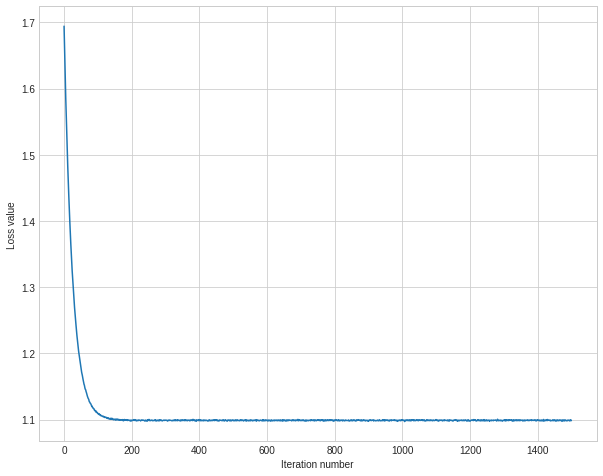

In [73]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [74]:
# Evaluate performance on both the training and validation sets
y_train_pred = softmaxclassifierObject.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_validate_pred = softmaxclassifierObject.predict(X_validate)
print('validation accuracy: %f' % (np.mean(y_validate == y_validate_pred), ))

training accuracy: 0.330370
validation accuracy: 0.312778


Learned weights =
[[ 2.19329245e-05 -4.27488847e-05]
 [ 2.32555547e-05  5.02669311e-05]
 [-4.51884792e-05 -7.51804641e-06]]
Learned bias =
[[-0.00098956]
 [-0.008972  ]
 [ 0.01164649]]


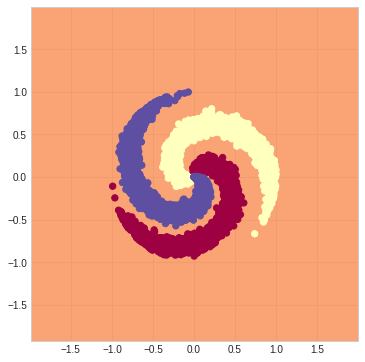

In [79]:
# Get the learned weights and bias
W_learned = softmaxclassifierObject.W[:, :-1]
print('Learned weights =')
print(W_learned)
b_learned = softmaxclassifierObject.W[:, -1].reshape(num_labels,-1)
print('Learned bias =')
print(b_learned)

# Function to extract correct category for each point (treated as a sample) in the 2D plane 
f = lambda x1, x2: np.argmax(np.dot(W_learned, np.array([x1, x2])) + b_learned, axis = 0)

# Generate 2D grid of points
x1, x2 = np.mgrid[np.min(X[0, :]) - 1:np.max(X[0, :]) + 1:100j,
                  np.min(X[1, :]) - 1:np.max(X[1, :]) + 1:100j]

# Calculate category corresponding to each point on the grid
S = f(x1.flatten(), x2.flatten()).reshape(x1.shape)

fig, ax = plt.subplots(1, 1, figsize = (6,6))
fig.tight_layout(pad = 4.0)
ax.contourf(x1, x2, S, cmap = plt.cm.Spectral, alpha = 0.8)
ax.scatter(X[0, :], X[1, :], c = y, s = 40, cmap = plt.cm.Spectral)
#ax.xlim(x1.min(), x1.max())
#ax.ylim(x2.min(), x2.max())
#fig.savefig('spiral_linear.png')
